In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nbodykit.lab as nb
import fitsio as ft
import numpy as np

In [2]:
plt.rc('font', family='serif', size=20)

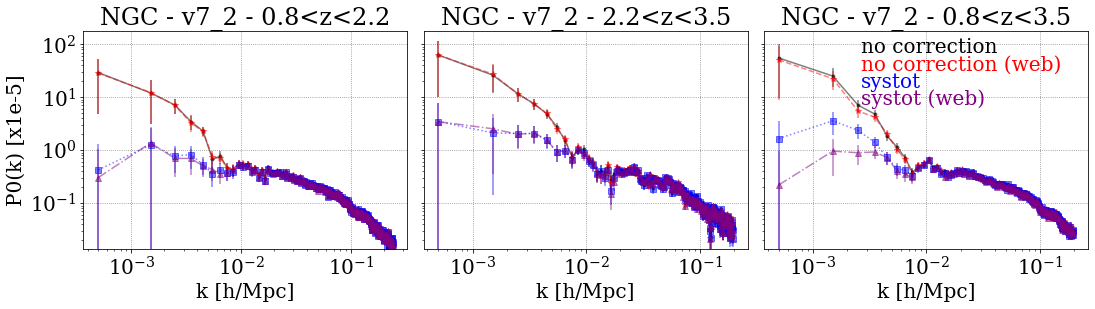

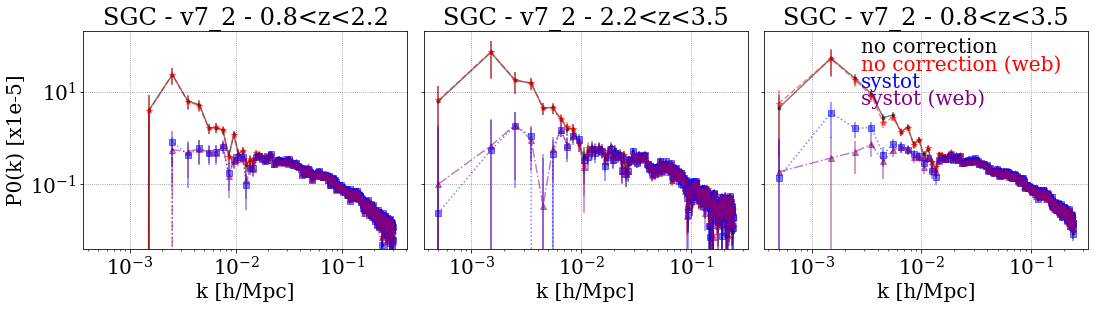

In [3]:
caps = ['NGC', 'SGC']
samples = ['standard', 'zhigh', 'combined']
ttl = ['no correction', 'no correction (web)', 'systot', 'systot (web)']
models = ['wosystot', 'wosystotnhiz', 'wsystot', 'wsystotnhiz']
#ttl     = ['systot',   'NN-plain',  'NN-ablation', 'NN-known', 'no correction']
#models  = ['wsystot',  'plain_lowmidhigh', 'ablation_lowmidhigh', 'known_lowmidhigh', 'wosystot']

mk = ['.', '*', 's', '^', '>', 'o']
c = ['k', 'r', 'b', 'purple', 'darkorange']
ls = 2*['-', '--', ':', '-.']
path = '/home/mehdi/data/eboss/v7_2/0.1/'
pkout = lambda cap, model, sample : f'pk_{cap}_v7_2_0.1_{model}_512_{sample}.json'
labels = {'standard':'0.8<z<2.2',
           'zhigh':'2.2<z<3.5',
          'combined':'0.8<z<3.5'} 

for cap in caps:    
    fig, ax = plt.subplots(ncols=3, figsize=(18, 4), sharey=True)
    ax = ax.flatten()
    fig.subplots_adjust(wspace=0.05)

    for j, sample in enumerate(samples):

        for i,model in enumerate(models):

            pk_i = nb.ConvolvedFFTPower.load(path + pkout(cap, model, sample))
            err = 1.e-5*pk_i.poles['power_0'].real/(0.5*pk_i.poles['modes'])**0.5
            
            ax[j].errorbar(pk_i.poles.coords['k'], 
                           1.e-5*(pk_i.poles['power_0'].real-pk_i.attrs['shotnoise']),
                           yerr=err,label=ttl[i], ls=ls[i], c=c[i], marker=mk[i], alpha=0.5)
            
            #if j==0:                
            #    Pkmock = np.loadtxt('/home/mehdi/data/eboss/v5/Power_Spectrum_DR16QSO_'+cap+'_av.txt', usecols=(0, 1))
            #    ax[j].plot(Pkmock[:, 0], 1.e-5*Pkmock[:, 1], c='grey')
                
            if j==2:
                ax[j].text(0.3, 0.9-i*0.08, ttl[i], color=c[i], transform=ax[j].transAxes)

        ax[j].set(yscale='log', xscale='log', 
                 xlabel='k [h/Mpc]',
                  title=f'{cap} - v7_2 - {labels[sample]}')
        if j==0:ax[j].set_ylabel('P0(k) [x1e-5]')
        ax[j].grid(True, ls=':', color='grey')
        # ax[j].legend(bbox_to_anchor=(1.,1.))        
        # plt.savefig('kpkv7_1_2z.png', dpi=300, bbox_inches='tight')

In [8]:
def test_cats(cap, tag=''):
    # -- read
    randomw = ft.read(f'/home/mehdi/data/eboss/v7_2/eBOSS_QSOandhiz_clustering_{cap}_v7_2.ran.fits')
    random = ft.read(f'/home/mehdi/data/eboss/v7_2/0.1/eBOSS_QSO_clustering_{cap}_v7_2_0.1{tag}.ran.fits')

    # Q1: any different columns?

    for colname in randomw.dtype.names:
        diff = np.setdiff1d(random[colname], randomw[colname])
        if not np.array_equal(diff, []):
            print(f'{colname} has {len(diff)}')


    # Z and Weight_Systot are different
    # Q2: what is the distribution of these two?

    fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
    c = ['k', 'r']

    for i, (n,r) in enumerate(zip(['full', 'web'], [random, randomw])):

        print('wsys:', np.percentile(r['WEIGHT_SYSTOT'], [0, 50, 100]))
        print('z:   ',  np.percentile(r['Z'], [0, 50, 100]))

        ax[0].hist(r['WEIGHT_SYSTOT'], range=(0.4, 2.0), bins=32, color=c[i], histtype='step')
        ax[1].hist(r['Z'], range=(0.8, 3.5), bins=54, color=c[i], histtype='step', 
                   weights=r['WEIGHT_CP']*r['WEIGHT_FKP']*r['WEIGHT_NOZ']*r['WEIGHT_SYSTOT'],
                   density=True)

        ax[0].text(0.8, 0.9-i*0.1, n.upper(), color=c[i], transform=ax[0].transAxes)

    ax[0].set(xlabel='WEIGHT_SYSTOT', yscale='log')
    ax[1].set(xlabel='Z') #, yscale='log')
    plt.show()


    # the full catalogs do not have randoms with systot > 1
    # Q3: is anything specifically different for wsys > 1 vs wsys < 1?

    wsys_gt_1 = randomw['WEIGHT_SYSTOT'] > 1
    for name in randomw[wsys_gt_1].dtype.names:
        print(f'{name:15s}, {np.percentile(randomw[wsys_gt_1][name], [0, 50, 100])}', end=' ')
        print(f'{np.percentile(randomw[~wsys_gt_1][name], [0, 50, 100])}')

Z has 842
WEIGHT_SYSTOT has 620
wsys: [0.5037037  0.98697068 1.        ]
z:    [0.80001524 1.64095605 3.49776889]
wsys: [0.41106581 0.97932495 1.87321573]
z:    [0.80001524 1.64039987 3.49776889]


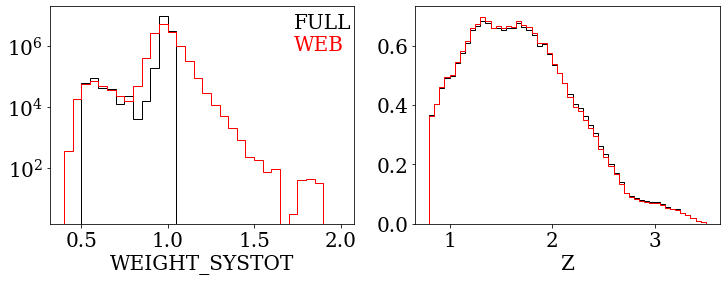

RA             , [109.71285957 173.8685974  263.2359112 ] [109.70737393 174.42142956 263.22565429]
DEC            , [16.00019367 41.93204505 59.99998516] [16.00001332 41.35794013 59.99999868]
Z              , [0.80003996 1.65853832 3.49776889] [0.80001524 1.63179164 3.49776889]
WEIGHT_FKP     , [0.88490545 0.90491525 1.        ] [0.88490545 0.90412735 1.        ]
WEIGHT_SYSTOT  , [1.00000002 1.03195456 1.87321573] [0.41106581 0.95952433 0.99999998]
WEIGHT_CP      , [1. 1. 4.] [1. 1. 4.]
WEIGHT_NOZ     , [1.         1.04267974 1.09279896] [1.         1.04295841 1.09336497]
NZ             , [0.00000000e+00 1.75126429e-05 2.16773725e-05] [0.00000000e+00 1.76731470e-05 2.16773725e-05]


In [9]:
test_cats('NGC')

# Q1: any different columns?
# Z and Weight_Systot are different

# Q2: what is the distribution of these two?
# the full catalogs do not have randoms with systot > 1

# Q3: is anything specifically different for wsys > 1 vs wsys < 1? nothing

Z has 910
WEIGHT_SYSTOT has 511
wsys: [0.5060241  0.98863636 1.        ]
z:    [0.80004008 1.64953743 3.49746618]
wsys: [2.14388728e-31 9.73950423e-01 1.87484365e+00]
z:    [0.80004008 1.64948299 3.49746618]


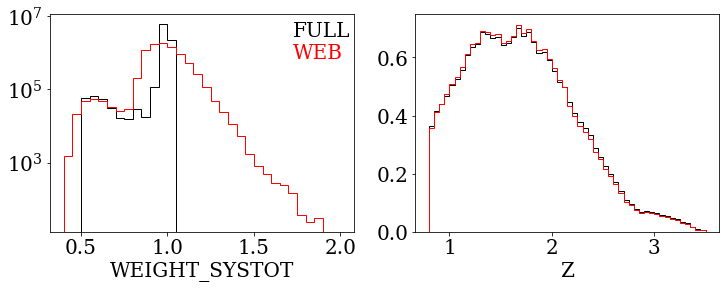

RA             , [3.32011922e-06 3.01432895e+01 3.59999978e+02] [9.73279057e-06 3.01576183e+01 3.59999973e+02]
DEC            , [-6.99997441 10.67871666 36.24952172] [-6.9990795  10.12708648 36.24898019]
Z              , [0.80007312 1.65911125 3.49746618] [0.80004008 1.64331109 3.49746618]
WEIGHT_FKP     , [0.89360387 0.9131721  1.        ] [0.89360387 0.91252504 1.        ]
WEIGHT_SYSTOT  , [1.0000001  1.06046562 1.87484365] [2.14388728e-31 9.27382771e-01 9.99999982e-01]
WEIGHT_CP      , [1. 1. 4.] [1. 1. 4.]
WEIGHT_NOZ     , [1.         1.05459454 1.08974705] [1.         1.05449578 1.08983046]
NZ             , [0.00000000e+00 1.58473039e-05 1.98440143e-05] [0.00000000e+00 1.59767227e-05 1.98440143e-05]


In [10]:
# How about SGC?
test_cats('SGC')

Z has 910
WEIGHT_SYSTOT has 5900976
wsys: [0.39464353 0.97170398 1.79790743]
z:    [0.80004008 1.64953743 3.49746618]
wsys: [2.14388728e-31 9.73950423e-01 1.87484365e+00]
z:    [0.80004008 1.64948299 3.49746618]


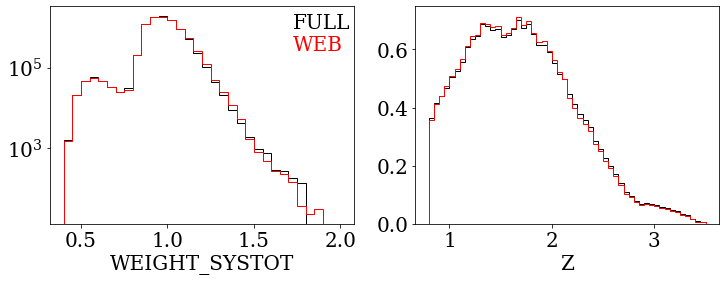

RA             , [3.32011922e-06 3.01432895e+01 3.59999978e+02] [9.73279057e-06 3.01576183e+01 3.59999973e+02]
DEC            , [-6.99997441 10.67871666 36.24952172] [-6.9990795  10.12708648 36.24898019]
Z              , [0.80007312 1.65911125 3.49746618] [0.80004008 1.64331109 3.49746618]
WEIGHT_FKP     , [0.89360387 0.9131721  1.        ] [0.89360387 0.91252504 1.        ]
WEIGHT_SYSTOT  , [1.0000001  1.06046562 1.87484365] [2.14388728e-31 9.27382771e-01 9.99999982e-01]
WEIGHT_CP      , [1. 1. 4.] [1. 1. 4.]
WEIGHT_NOZ     , [1.         1.05459454 1.08974705] [1.         1.05449578 1.08983046]
NZ             , [0.00000000e+00 1.58473039e-05 1.98440143e-05] [0.00000000e+00 1.59767227e-05 1.98440143e-05]


In [11]:
# How about SGC? but with a NN-based random
test_cats('SGC', '_known_allhigh')

In [7]:
import pandas as pd

In [4]:
import sys
sys.path.insert(0, '/home/mehdi/github/LSSutils')
from LSSutils.catalogs import combinefits as cf

camb is not installed!


In [3]:
LSS.setup_logging("info")

In [9]:
templates = pd.read_hdf('/home/mehdi/data/eboss/sysmaps/SDSS_WISE_HI_imageprop_nside512.h5',key='templates')

In [10]:
templates.head()

,nran,sky_g,sky_r,sky_i,sky_z,airmass,ebv,depth_g,depth_r,depth_i,...,psf_r,psf_i,psf_z,w1_med,w1_covmed,w1_moon,star_density,loghi,run,depth_g_minus_ebv
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.321053,53.861678,0.0,0.0,20.802680,NaN,NaN
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.247458,56.505509,0.0,0.0,20.787574,NaN,NaN
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.247467,56.505200,0.0,0.0,20.776386,NaN,NaN
3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.321044,53.861987,0.0,0.0,20.788406,NaN,NaN
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.324270,53.746094,0.0,0.0,20.805544,NaN,NaN


In [6]:
qso    = cf.EbossCatalog('/home/mehdi/data/eboss/v7_2/eBOSS_QSO_full_NGC_v7_2.dat.fits', kind='galaxy')
random = cf.EbossCatalog('/home/mehdi/data/eboss/v7_2/eBOSS_QSO_full_NGC_v7_2.ran.fits', kind='random')
qsohighz    = cf.EbossCatalog('/home/mehdi/data/eboss/v7_2/eBOSS_QSO_full_NGC_v7_2.dat.fits', kind='galaxy', zmin=2.2, zmax=3.5)
randomhighz = cf.EbossCatalog('/home/mehdi/data/eboss/v7_2/eBOSS_QSO_full_NGC_v7_2.ran.fits', kind='random', zmin=2.2, zmax=3.5)

[ 000271.70 ]   0: 02-13 21:15  EbossCatalog    INFO     compmin : 0.5
[ 000271.70 ]   0: 02-13 21:15  EbossCatalog    INFO     zmin:0.8, zmax:2.2
[ 000271.80 ]   0: 02-13 21:15  EbossCatalog    INFO     218209 galaxies pass the cuts
[ 000271.80 ]   0: 02-13 21:15  EbossCatalog    INFO     % of galaxies after cut 0.54
[ 000273.18 ]   0: 02-13 21:15  EbossCatalog    INFO     compmin : 0.5
[ 000273.18 ]   0: 02-13 21:15  EbossCatalog    INFO     zmin:0.8, zmax:2.2
[ 000274.14 ]   0: 02-13 21:15  EbossCatalog    INFO     11099858 randoms pass the cuts
[ 000274.17 ]   0: 02-13 21:15  EbossCatalog    INFO     % of randoms after cut 0.64
[ 000278.19 ]   0: 02-13 21:15  EbossCatalog    INFO     compmin : 0.5
[ 000278.19 ]   0: 02-13 21:15  EbossCatalog    INFO     zmin:2.2, zmax:3.5
[ 000278.71 ]   0: 02-13 21:15  EbossCatalog    INFO     46679 galaxies pass the cuts
[ 000278.72 ]   0: 02-13 21:15  EbossCatalog    INFO     % of galaxies after cut 0.12
[ 000279.92 ]   0: 02-13 21:15  EbossCata

In [14]:
usemaps = ['star_density', 'ebv', 'psf_i', 'sky_i', 'depth_g_minus_ebv', 'airmass']

In [15]:
from LSSutils.stats.nnbar import NNBAR

In [17]:
from LSSutils.utils import hpixsum

In [22]:
import matplotlib.pyplot as plt
import healpy as hp

In [29]:
LSS.setup_logging("warning")

In [42]:
nside=512
zcuts={'low':[0.8,1.5],
      'high':[1.5,2.2],
      'all':[0.8,2.2],
      'zhigh':[2.2,3.5]}

results= {}



for zcut in zcuts:
    
    if zcut=='zhigh':
        sample=qsohighz
        ransom=randomhighz
    else:
        sample=qso
        ransom=random
        
    
    sample.cutz(zcuts[zcut])
    weight = sample.cdata['WEIGHT_CP']*sample.cdata['WEIGHT_FKP']*sample.cdata['WEIGHT_NOZ']        
    sample.hpmap= hpixsum(nside, sample.cdata['RA'], sample.cdata['DEC'], value=weight*sample.cdata['WEIGHT_SYSTOT'])
    sample.hpmap2 = hpixsum(nside, sample.cdata['RA'], sample.cdata['DEC'], value=weight)

    weight = ransom.data['WEIGHT_CP']*ransom.data['WEIGHT_FKP']*ransom.data['WEIGHT_NOZ']*ransom.data['WEIGHT_SYSTOT']      
    ransom.hpmap = hpixsum(nside, ransom.data['RA'], ransom.data['DEC'], value=weight)
    
    mask  = ransom.hpmap > 0
    
    for mapi in usemaps:
        
        print(zcut, mapi)
        
        sysmap = templates[mapi].values
        
        nnbar = NNBAR(sample.hpmap,
                      ransom.hpmap, 
                      mask, 
                      sysmap, 
                      nbins=5, 
                      binning='equi-area')
        
        nnbar.run()
        results['-'.join((zcut, mapi, 'after'))]=nnbar.output
        
        
        nnbar = NNBAR(sample.hpmap2,
                      ransom.hpmap, 
                      mask, 
                      sysmap, 
                      nbins=5, 
                      binning='equi-area')
        
        nnbar.run()
        results['-'.join((zcut, mapi, 'before'))]=nnbar.output

low star_density
low ebv
low psf_i
low sky_i
low depth_g_minus_ebv
low airmass
high star_density
high ebv
high psf_i
high sky_i
high depth_g_minus_ebv
high airmass
all star_density
all ebv
all psf_i
all sky_i
all depth_g_minus_ebv
all airmass
zhigh star_density
zhigh ebv
zhigh psf_i
zhigh sky_i
zhigh depth_g_minus_ebv
zhigh airmass


In [33]:
results['low-star_density']

{'nnbar': array([0.99961654, 1.02554634, 1.02877456, 0.98501248, 0.96104728]),
 'area': array([2494.00558967, 2494.0279944 , 2494.04618155, 2494.01592255,
        2493.86701311]),
 'nnbar_err': array([0.00606755, 0.00485741, 0.0068035 , 0.0079944 , 0.00726452]),
 'bin_edges': array([  2.25,  15.25,  18.  ,  22.75,  33.  , 127.  ]),
 'attr': {'njack': 20,
  'nbar': 0.010401604220658386,
  'nside': 256,
  'npix2area': 0.0012695251307729102}}

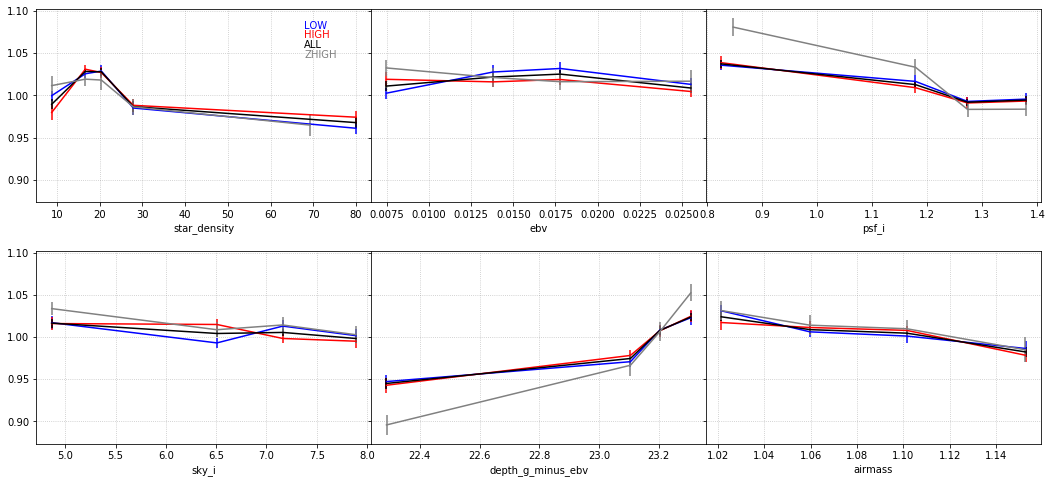

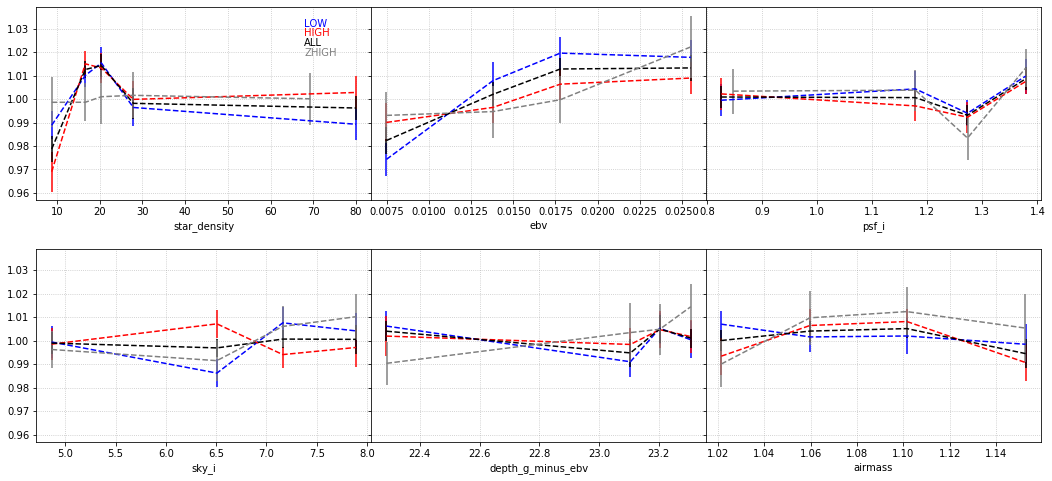

In [56]:
color = {'low':'b',
         'high':'r',
         'all':'k',
         'zhigh':'grey'}
ls = {'before':'-',
      'after':'--'}




for k, wght in enumerate(['before', 'after']):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 8),
                          sharey=True)
    fig.subplots_adjust(hspace=0.25, wspace=0.0)
    ax = ax.flatten()

    
    for j,zcut in enumerate(zcuts):
        for i,mapi in enumerate(usemaps):            
            myr=results['-'.join((zcut, mapi, wght))]
            x    = myr['bin_edges']
            xmid = 0.5*(x[1:]+x[:-1])
            y  = myr['nnbar']
            ye = myr['nnbar_err']
#             if wght=='after':ye=0
            ax[i].errorbar(xmid, y, ye, color=color[zcut], ls=ls[wght])
            
            if i==0:
                
                ax[0].text(0.8, 0.9-j*0.05, zcut.upper(), color=color[zcut], transform=ax[0].transAxes)
            if j==0:
                ax[i].set(xlabel=mapi)
                ax[i].grid(True, ls=':', color='grey', alpha=0.5)
plt.show()

In [59]:
id(qso), id(qsohighz)

(139694903967376, 139694902803216)

In [60]:
id?

In [71]:
a = [2, 1]
b = [5, 1]
print(a, b)
print(id(a), id(b))
c = a
c.append(3)
print(a, b, c)
print(id(a), id(b), id(c))

c = b
c.append(3)
print(a, b, c)
print(id(a), id(b), id(c))

[2, 1] [5, 1]
139693850964128 139693849252080
[2, 1, 3] [5, 1] [2, 1, 3]
139693850964128 139693849252080 139693850964128
[2, 1, 3] [5, 1, 3] [5, 1, 3]
139693850964128 139693849252080 139693849252080


In [95]:
!ls /home/mehdi/data/eboss/v7_2/0.1/results/NGC_*_512/regression/nn_plain/nn-weights.hp512.fits

/home/mehdi/data/eboss/v7_2/0.1/results/NGC_all_512/regression/nn_plain/nn-weights.hp512.fits
/home/mehdi/data/eboss/v7_2/0.1/results/NGC_high_512/regression/nn_plain/nn-weights.hp512.fits
/home/mehdi/data/eboss/v7_2/0.1/results/NGC_low_512/regression/nn_plain/nn-weights.hp512.fits
/home/mehdi/data/eboss/v7_2/0.1/results/NGC_zhigh_512/regression/nn_plain/nn-weights.hp512.fits


In [96]:
nnmap = lambda x:f'/home/mehdi/data/eboss/v7_2/0.1/results/NGC_{x}_512/regression/nn_plain/nn-weights.hp512.fits'

In [97]:
import numpy as np

In [98]:
nside=512
zcuts={'low':[0.8,1.5],
      'high':[1.5,2.2],
      'all':[0.8,2.2],
      'zhigh':[2.2,3.5]}


for zcut in zcuts:
    
    if zcut=='zhigh':
        sample=qsohighz
        ransom=randomhighz
    else:
        sample=qso
        ransom=random
        
    
    sample.cutz(zcuts[zcut])
    sample.tohp(nside)
    
    ransom.tohp(nside)
        
    mask  = ransom.hpmap > 0
    
    weight = hp.read_map(nnmap(zcut), verbose=False)
    nan = np.isnan(weight)
    weight[nan] = 1.0
    
    for mapi in usemaps:
        
        print(zcut, mapi)
        
        sysmap = templates[mapi].values
        
        nnbar = NNBAR(sample.hpmap,
                      ransom.hpmap, 
                      mask, 
                      sysmap, 
                      selection=weight,
                      nbins=5, 
                      binning='equi-area')
        
        nnbar.run()
        results['-'.join((zcut, mapi, 'afternnp'))]=nnbar.output

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


low star_density
low ebv
low psf_i
low sky_i
low depth_g_minus_ebv
low airmass
high star_density
high ebv
high psf_i
high sky_i
high depth_g_minus_ebv
high airmass
all star_density
all ebv
all psf_i
all sky_i
all depth_g_minus_ebv
all airmass
zhigh star_density
zhigh ebv
zhigh psf_i
zhigh sky_i
zhigh depth_g_minus_ebv
zhigh airmass


In [92]:
import matplotlib.backends.backend_pdf

In [99]:
pdf = matplotlib.backends.backend_pdf.PdfPages("nnbar_v7_2.pdf")

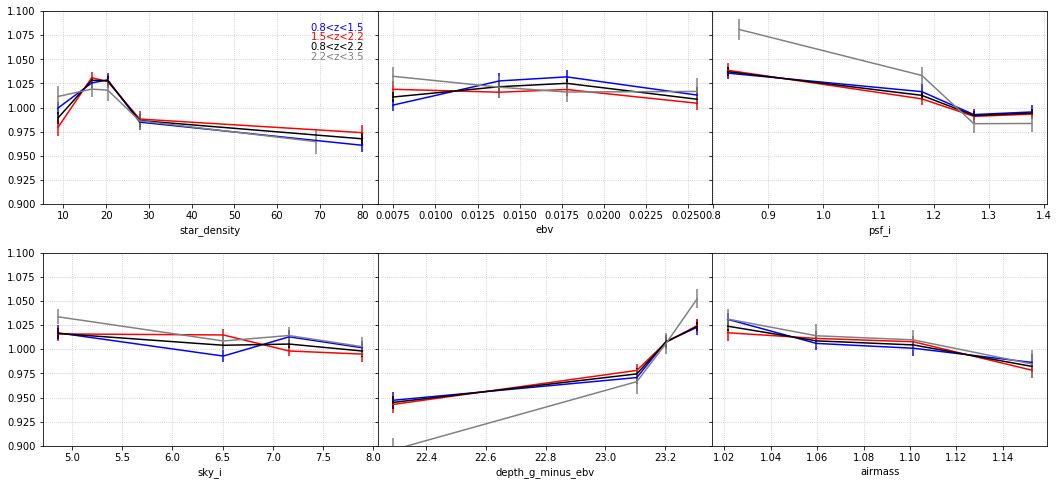

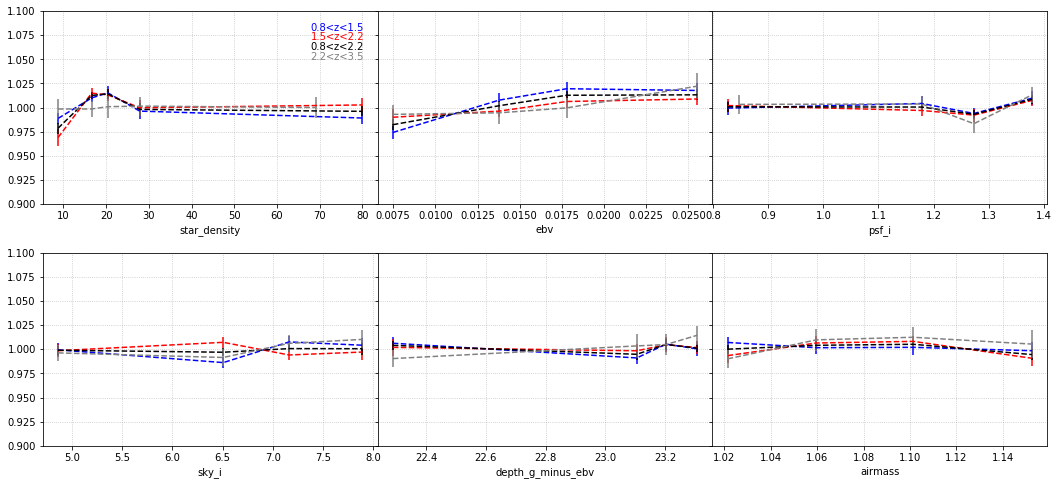

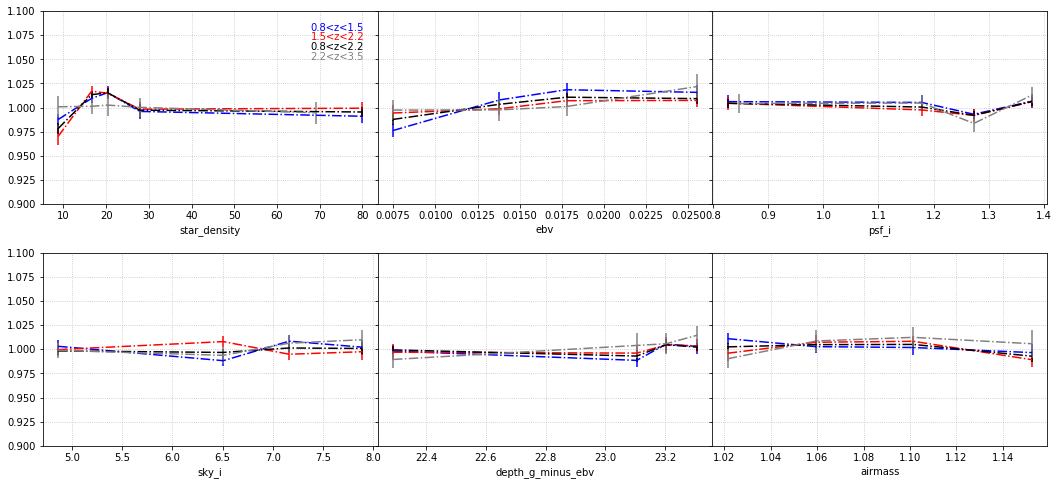

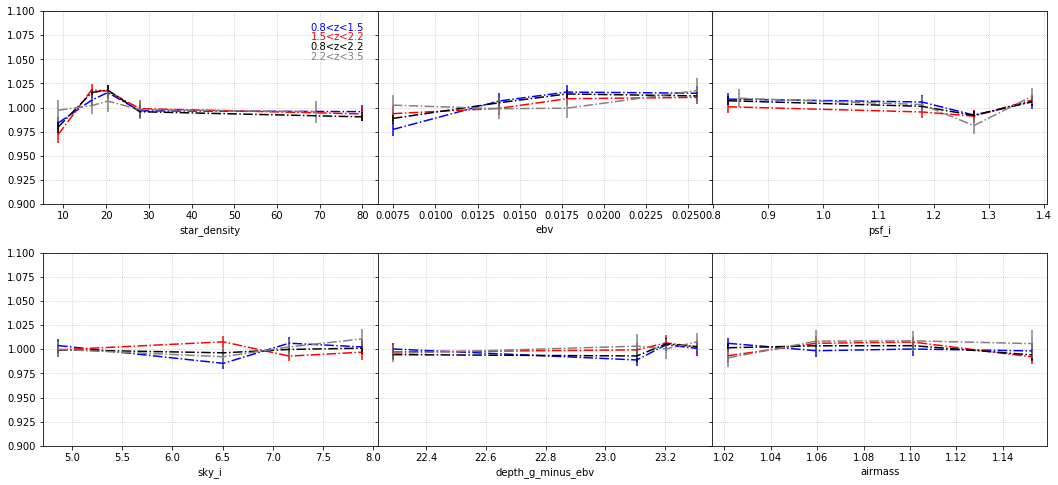

In [100]:
color = {'low':'b',
         'high':'r',
         'all':'k',
         'zhigh':'grey'}

ls = {'before':'-',
      'after':'--',
      'afternn':'-.',
      'afternnp':'-.'}

labels = {'low':'0.8<z<1.5',
         'high':'1.5<z<2.2',
         'all':'0.8<z<2.2',
         'zhigh':'2.2<z<3.5'}


for k, wght in enumerate(['before', 'after', 'afternn', 'afternnp']):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 8),
                          sharey=True)
    fig.subplots_adjust(hspace=0.25, wspace=0.0)
    ax = ax.flatten()

    
    for j,zcut in enumerate(zcuts):
        for i,mapi in enumerate(usemaps):            
            myr=results['-'.join((zcut, mapi, wght))]
            x    = myr['bin_edges']
            xmid = 0.5*(x[1:]+x[:-1])
            y  = myr['nnbar']
            ye = myr['nnbar_err']
#             if wght=='after':ye=0
            ax[i].errorbar(xmid, y, ye, color=color[zcut], ls=ls[wght])
            
            if i==0:
                
                ax[0].text(0.8, 0.9-j*0.05, labels[zcut], color=color[zcut], transform=ax[0].transAxes)
            if j==0:
                ax[i].set(xlabel=mapi, ylim=(0.9,1.1))
                ax[i].grid(True, ls=':', color='grey', alpha=0.5)
    pdf.savefig((k+1), bbox_inches='tight')
pdf.close()